This notebook picks a bunch of healpix pixels, and places a mock cluster at the center of each

And adds shear to background objects

In [104]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp


import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle
import glob
import healpy as hp
import images

import multiprocessing as mp

import synthetic.tools as tools
import synthetic.emulator.emulator as emulator
import synthetic.emulator.indexer as indexer
import synthetic.emulator.reader as reader
import synthetic.render.frame as frame
import synthetic.render.render as render

In [86]:
folder_path = "/e/ocean1/users/vargatn/LSST/SYNTHETIC/"

In [87]:
in_path = "/e/ocean1/users/vargatn/LSST/DC2_1.1.4/"

In [88]:
fnames = glob.glob(in_path + "*pixel*h5")
pixels = np.array([int(tmp.split("-")[-1].split(".")[0]) for tmp in fnames])

In [89]:
pixel_id = 0

In [90]:
alltable = pd.read_hdf(fnames[pixel_id], key='data')
ra_cen = np.mean(alltable["ra"])
dec_cen = np.mean(alltable["dec"])

In [91]:
pad = 0.17 # degree
mag_max = 25

ii = (np.abs(alltable["ra"] - ra_cen) < pad) & (np.abs(alltable["dec"] - dec_cen) < pad) & (alltable['mag_i'] < mag_max)
table = alltable[ii]
ra = (table["ra"] - ra_cen) * 60. 
dec = (table["dec"] - dec_cen) * 60.

# This is the pre injection canvas

In [92]:
pixel_scale = 0.264
mock_catalog = pd.DataFrame()
mock_catalog["RA"] = table["ra"]
mock_catalog["DEC"] = table["dec"]
mock_catalog["X"] = (table["ra"] - ra_cen) * 60 * 60 / pixel_scale + 2499.5
mock_catalog["Y"] = (table["dec"] - dec_cen) * 60 * 60 / pixel_scale + 2499.5

mock_catalog["MAG_I"] = table["mag_i"]
mock_catalog["TSIZE"] = table["size_true"]
mock_catalog["FRACDEV"] = 0
mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
mock_catalog["G1"] = table["ellipticity_1_true"]
mock_catalog["G2"] = table["ellipticity_2_true"]

In [118]:
def make_mock(table, sky_center,  pixel_scale=0.264, image_offset=(2499.5, 2499.5)):
    pixel_scale = 0.264
    mock_catalog = pd.DataFrame()
    mock_catalog["RA"] = table["ra"]
    mock_catalog["DEC"] = table["dec"]
    mock_catalog["X"] = (table["ra"] - sky_center[0]) * 60 * 60 / pixel_scale + image_offset[0]
    mock_catalog["Y"] = (table["dec"] - sky_center[1]) * 60 * 60 / pixel_scale + image_offset[1]

    mock_catalog["MAG_G"] = table["mag_g"]
    mock_catalog["FLUX_G"] = tools.toflux(table["mag_g"])
    mock_catalog["MAG_R"] = table["mag_i"]
    mock_catalog["FLUX_R"] = tools.toflux(table["mag_r"])
    mock_catalog["MAG_I"] = table["mag_i"]
    mock_catalog["FLUX_I"] = tools.toflux(table["mag_i"])
    mock_catalog["MAG_Z"] = table["mag_z"]
    mock_catalog["FLUX_Z"] = tools.toflux(table["mag_z"])

    mock_catalog["TSIZE"] = table["size_true"]
    mock_catalog["FRACDEV"] = 0
    mock_catalog["G1"] = table["ellipticity_1_true"]
    mock_catalog["G2"] = table["ellipticity_2_true"]    
    return mock_catalog

In [119]:
mock_catalog = make_mock(table, sky_center=(ra_cen, dec_cen))

In [78]:
len(table) / (0.1 * 60)**2.

378.6666666666667

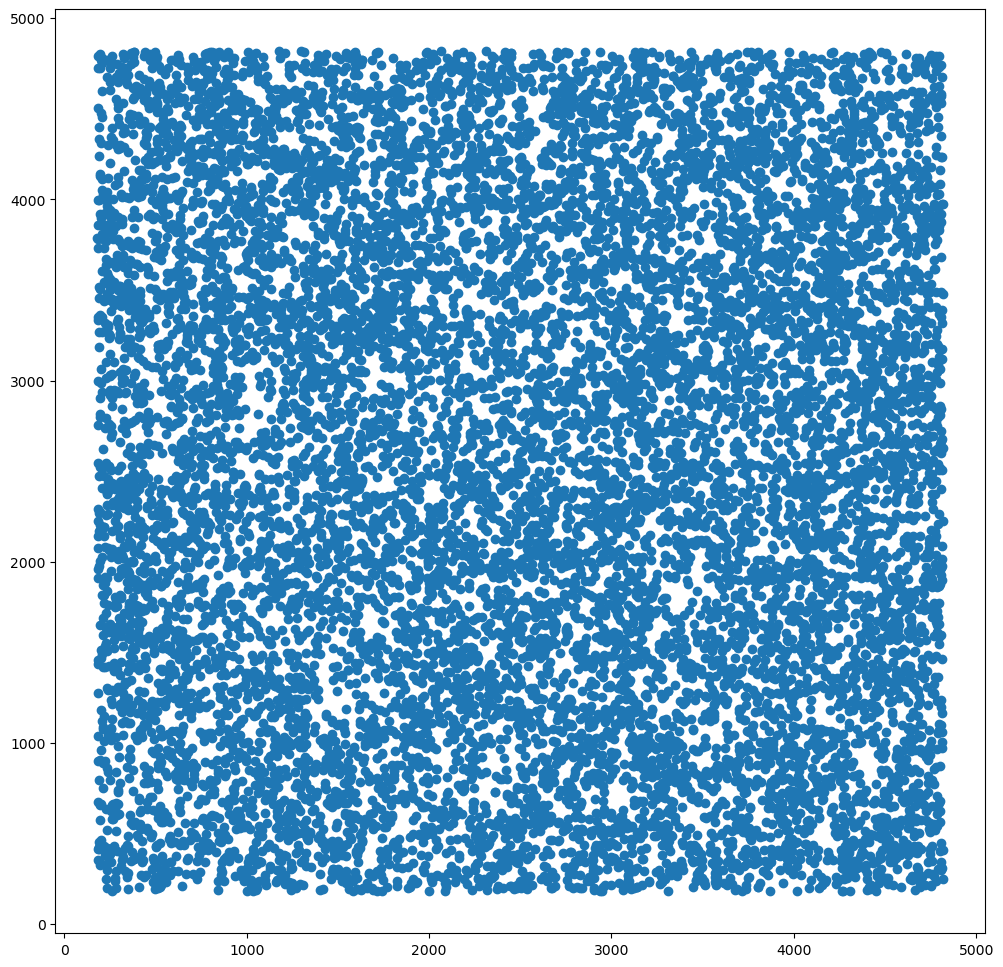

In [79]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)


ax.scatter(mock_catalog["X"], mock_catalog["Y"])

In [121]:
stds = np.array([2.509813, 5.192254, 8.36335, 15.220351]) / 1.3
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band
    print(name)
    fr = frame.Frame(mock_catalog.to_records(), band=band, name=name,
                     center=(ra_cen, dec_cen), noise_std=stds[i], canvas_size=5000)
    fr.render() 

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r
starting xshear calculations in 100 processes
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i
starting xshear calculations in 100 processes


In [122]:
ims_all = []
for i, band in enumerate(("g", "r", "i")):
    name = folder_path + 'test_canvas_grid_' + band + ".fits"
    tmp = fio.read(name)
    print(name)
    ims_all.append(tmp)

/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_g.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_r.fits
/e/ocean1/users/vargatn/LSST/SYNTHETIC/test_canvas_grid_i.fits


0.9392495155334473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0, 0.5, 'Y [pix]')

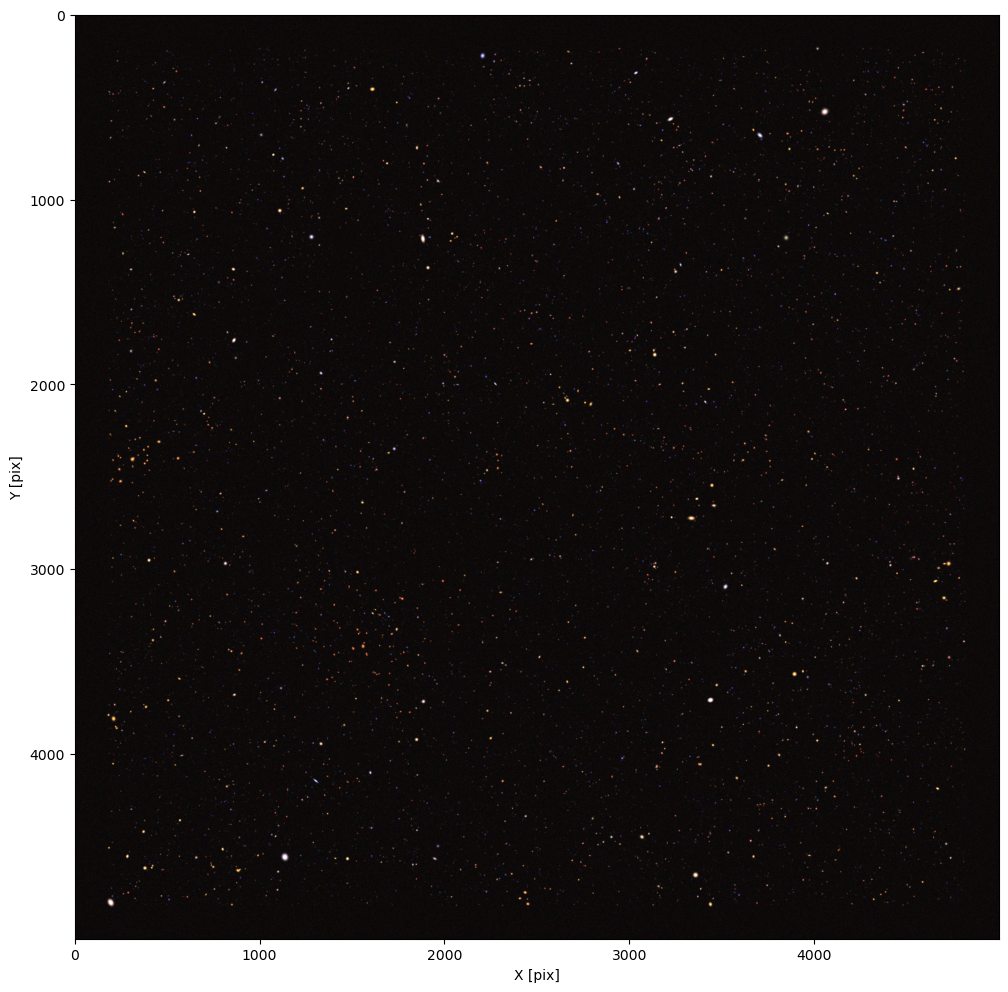

In [126]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 0.01
scales = np.array([1., 1.2, 2.5]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(ims_all[2],# + ims_icl[2] + noises[2] + pad,
                                ims_all[1],# + ims_icl[1] + noises[1] + pad,
                                ims_all[0],# + ims_icl[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * 2, origin='upper')

# ax.set_title("cluster + field rendered together")

ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
# fig.savefig("all_01.png", bbox_inches='tight')

Let'

In [127]:
table["halo_"]

redshift_true      mag_g        halo_id  Mag_true_i_lsst_z0  \
5              0.006372  16.948526      400151487          -16.220596   
10             0.007462  19.248011     -300151487          -13.852721   
40             0.016559  21.236643    -3300151487          -13.568752   
48             0.012715  20.459301    -4100151487          -14.148746   
62             0.018134  18.759460    -5500151487          -16.229250   
...                 ...        ...            ...                 ...   
16568781       2.993788  25.206673  1447200151121          -22.287796   
16575471       2.972810  24.796883  2004500151121          -21.664640   
16589159       2.948629  25.340083  3174400151121          -22.036610   
16596437       2.942486  24.610996  3786300151121          -21.977777   
16610321       2.958145  24.832836  4967700151121          -23.152044   

                dec   shear_1  ellipticity_1_true  Mag_true_z_lsst_z0  \
5        -40.077991 -0.000000           -0.056183          -16.422611   
10       -40.108242 -0.000000            0.162750          -13.918885   
40       -40.082341 -0.000000            0.009457          -13.619755   
48       -40.313013 -0.000000           -0.285715          -14.283675   
62       -40.395966 -0.000000           -0.089482          -16.314856   
...             ...       ...                 ...                 ...   
16568781 -40.091262 -0.014620            0.029729          -22.349319   
16575471 -40.384998 -0.001122            0.009299          -21.724075   
16589159 -40.295619 -0.003395            0.001880          -22.099953   
16596437 -40.385250  0.032796           -0.006149          -22.109646   
16610321 -40.180175 -0.022575           -0.004273          -23.249788   

          Mag_true_r_lsst_z0      mag_r  ...  ellipticity_2_true  \
5                 -15.884542  16.299500  ...            0.043783   
10                -13.651316  18.874130  ...            0.652628   
40                -13.403417  20.870258  ...           -0.000912   
48                -13.847451  19.857061  ...            0.231496   
62                -16.053469  18.419153  ...           -0.043213   
...                      ...        ...  ...                 ...   
16568781          -22.208088  24.846598  ...           -0.023869   
16575471          -21.600676  24.581772  ...           -0.002632   
16589159          -21.962965  24.872281  ...           -0.001546   
16596437          -21.817165  24.419668  ...           -0.008227   
16610321          -23.016890  24.562012  ...            0.013920   

          Mag_true_g_lsst_z0  stellar_mass      mag_i   shear_2  is_central  \
5                 -15.244349  4.052223e+07  15.962165  0.000000        True   
10                -13.283442  2.684141e+06  18.669321  0.000000        True   
40                -13.046698  1.721090e+06  20.689413  0.000000        True   
48                -13.256854  2.352484e+06  19.547430  0.000000        True   
62                -15.721539  4.140120e+07  18.233431  0.000000        True   
...                      ...           ...        ...       ...         ...   
16568781          -22.061844  3.785350e+10  24.756514 -0.046407        True   
16575471          -21.528019  1.102463e+10  24.570818 -0.029981        True   
16589159          -21.870026  1.783753e+10  24.761638 -0.017941        True   
16596437          -21.617489  2.512281e+10  24.466030 -0.007141        True   
16610321          -22.739861  1.557854e+11  24.463285 -0.071749        True   

                 ra      mag_z     halo_mass   galaxy_id  
5         50.545188  15.757197  5.205493e+10  9437500005  
10        50.557417  18.598883  1.548140e+10  9437500010  
40        50.605921  20.637552  1.479444e+10  9437500040  
48        50.702202  19.403072  1.193423e+10  9437500048  
62        50.623632  18.146929  2.565134e+10  9437500062  
...             ...        ...           ...         ...  
16568781  50.529856  24.727661  1.811504e+12  9457658074  
16575471  50.57107

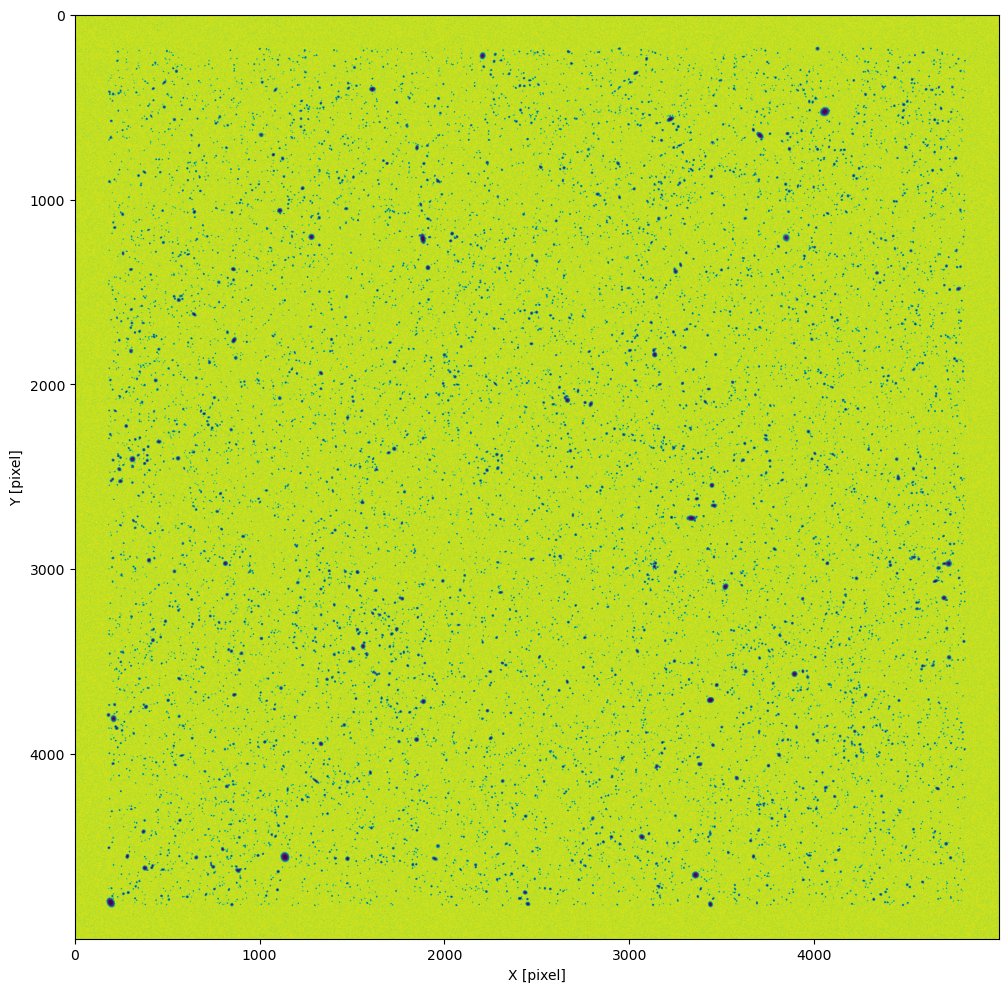

In [84]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
arr = fr.canvas.array
ax.imshow(np.arcsinh(arr) / arr)
ax.set_xlabel("X [pixel]")
ax.set_ylabel("Y [pixel]")

fig.savefig("DC2_noinject_render.png")